Let's look at some light curves pulled from the GOTO marshall. The light curves shown here have been matched to known sources from other catalogues (Transient Name Server and SIMBAD) to identify their type. The two examples are a variable star and a supernova.

In [1]:
# import statements
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import FeatureFunctions as fats

In [2]:
# Method to plot light curves
def plot_lc(time, mag, magerr, color):
    
    plt.figure(figsize=(6,4))
    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    
    plt.errorbar(time, mag, yerr=magerr, linestyle='None', marker='o', color=color)
    
    return plt

In [3]:
# Read in example supernova light curve
sn_lc = pd.read_csv('SN 2019euw_lightcurve.csv')

# Read in example variable star light curve
vs_lc = pd.read_csv('IRAS 18547+1254_lightcurve.csv')

Let's plot the light curves to see what they look like.

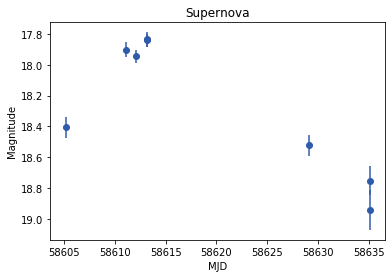

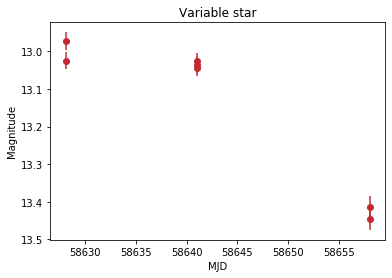

In [4]:
# Plot supernova light curve
t_sn = sn_lc['jd'].values - 2400000.5    # Convert to MJD
mag_sn = sn_lc['mag'].values
magerr_sn = sn_lc['mag_err'].values

sn_color = '#305BAB'

sn_plot = plot_lc(t_sn, mag_sn, magerr_sn, sn_color)
sn_plot.title('Supernova')
sn_plot.show()

# Plot variable star light curve
t_vs = vs_lc['jd'].values - 2400000.5
mag_vs = vs_lc['mag'].values
magerr_vs = vs_lc['mag_err'].values

vs_color = '#C32934'

vs_plot = plot_lc(t_vs, mag_vs, magerr_vs, vs_color)
vs_plot.title('Variable star')
vs_plot.show()

Looking at the data, we see that the typical time between points on the light curve is $\sim$ 10 days. At the moment GOTO only observes in a single optical filter ($L$), so light curves are only available in single band. Can we classify these light curves into separate classes?

The first step to classifying with a machine learning algorithm is to extract some __features__ from the light curves. Features should be able to describe what makes a class of objects distinct from others. The goal of a machine learning classifier is to learn the __feature-class__ relationship so that it can make predictions on new data to decide which class of objects it belongs to.

The features we'll use will be those implemented in Feature Analysis for Time-Series (FATS) (Nun et al. 2015 http://isadoranun.github.io/tsfeat/). I've written a Python 3 implementation of the features in `FeatureFunctions.py`.

In addition to the FATS features, I've also included some additional features to take into account the quality of the data:
- `mean_spacing`: the mean time between successive points on the light curve
- `abv_thresh`: the difference between the GOTO magnitude limit (taken to be 20 mag) and the median magnitude of the light curve
- `n_epochs`: the number of epochs observed in days, points are binned into 1 day bins

In [5]:
# Method extract features from a light curve and save to a dictionary
def get_FATS(magnitude, time, magnitude_err):
    
    data = [magnitude, time, magnitude_err]
    
    peak_mag = fats.PeakMag(data)
    amplitude = fats.Amplitude(data)
    rcs = fats.Rcs(data)
    stetk = fats.StetsonK(data)
    mean = fats.Mean(data)
    meanvar = fats.Meanvariance(data)
    acl = fats.Autocor_length(data)
    con = fats.Con(data)
    beyond1std = fats.Beyond1std(data)
    std = fats.Std(data)
    skew = fats.Skew(data)
    maxslope = fats.MaxSlope(data)
    med_abs_dev = fats.MedianAbsDev(data)
    med_brp = fats.MedianBRP(data)
    f_mid20 = fats.FluxPercentileRatioMid20(data)
    f_mid35 = fats.FluxPercentileRatioMid35(data)
    f_mid50 = fats.FluxPercentileRatioMid50(data)
    f_mid65 = fats.FluxPercentileRatioMid65(data)
    f_mid80 = fats.FluxPercentileRatioMid80(data)
    percent_diff = fats.PercentDifferenceFluxPercentile(data)
    percent_ampl = fats.PercentAmplitude(data)
    lin_trend = fats.PercentAmplitude(data)
    q_31 = fats.Q31(data)
    anders_t = fats.AndersonDarling(data)
    period_ls = fats.PeriodLS(data)
    period_fit = fats.PeriodFit(data)
    psi_cs = fats.Psi_CS(data)
    psi_eta = fats.Psi_eta(data)
    gskew = fats.Gskew(data)
    str_func_21 = fats.StructureFunction_index_21(data)
    str_func_31 = fats.StructureFunction_index_31(data)
    str_func_32 = fats.StructureFunction_index_32(data)
    mean_spacing = fats.MeanSpacing(data)
    abv_thresh = fats.AboveThreshold(data, 20.0)
    n_epochs = fats.NumEpochs(data)
    
    features_dict = {'peak_mag':peak_mag,
                     'amplitude':amplitude,
                     'range_cumulative_sum':rcs,
                     'stetson_k':stetk,
                     'mean_mag':mean,
                     'mean_var':meanvar,
                     'autocorr_len':acl,
                     'con':con,
                     'beyond_1std':beyond1std,
                     'std_dev':std,
                     'skew':skew,
                     'max_slope':maxslope,
                     'median_abs_dev':med_abs_dev,
                     'median_buffer_range_percent':med_brp,
                     'flux_ratio_mid20':f_mid20,
                     'flux_ratio_mid35':f_mid35,
                     'flux_ratio_mid50':f_mid50,
                     'flux_ratio_mid65':f_mid65,
                     'flux_ratio_mid80':f_mid80,
                     'percent_diff_flux_percentile':percent_diff,
                     'percent_amplitude':percent_ampl,
                     'linear_trend':lin_trend,
                     'Q3_Q1_diff':q_31,
                     'anderson_darling_t':anders_t,
                     'lomb_scargle_period':period_ls,
                     'lomb_scargle_fit':period_fit,
                     'psi_cumulative_sum':psi_cs,
                     'psi_eta':psi_eta,
                     'gskew':gskew,
                     'structure_func_21':str_func_21,
                     'structure_func_31':str_func_31,
                     'structure_func_32':str_func_32,
                     'mean_spacing':mean_spacing,
                     'above_threshold':abv_thresh,
                     'n_epochs':n_epochs}
    
    return features_dict

In [6]:
# Extract features from the light curves
vs_features = get_FATS(mag_vs, t_vs, magerr_vs)
sn_features = get_FATS(mag_sn, t_sn, magerr_sn)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [42]:
# View the features
vs_features_df = pd.DataFrame([vs_features, sn_features])
vs_features_df = vs_features_df.rename(index={0:'variable star', 1:'supernova'})
vs_features_df.transpose()

,variable star,supernova
Q3_Q1_diff,0.203500,0.694150
above_threshold,6.963300,1.825150
amplitude,0.236400,0.553450
anderson_darling_t,0.999403,0.874087
autocorr_len,2.000000,2.000000
beyond_1std,0.285714,0.250000
con,0.000000,0.000000
flux_ratio_mid20,0.025755,0.475499
flux_ratio_mid35,0.084127,0.556006
flux_ratio_mid50,0.454952,0.668207


The next step is to perform feature extraction on all the data!